In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


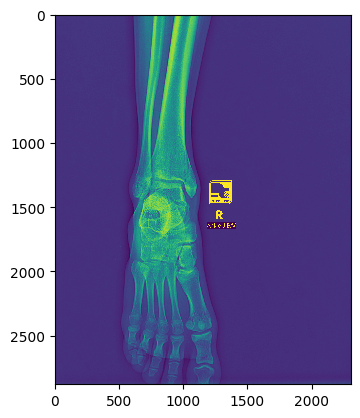

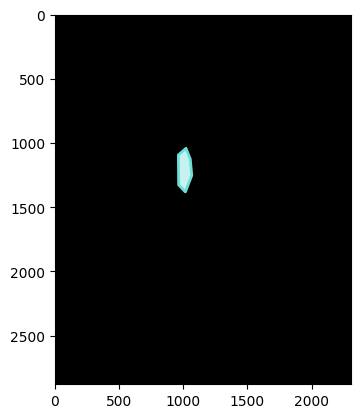

Loaded pretrained weights for efficientnet-b6


100%|██████████| 205/205 [08:42<00:00,  2.55s/it]


Epoch [1/10], Loss: 0.4051
Validation Accuracy: 0.8624


100%|██████████| 205/205 [09:03<00:00,  2.65s/it]


Epoch [2/10], Loss: 0.3441
Validation Accuracy: 0.8870


100%|██████████| 205/205 [09:02<00:00,  2.65s/it]


Epoch [3/10], Loss: 0.2965
Validation Accuracy: 0.9042


100%|██████████| 205/205 [09:07<00:00,  2.67s/it]


Epoch [4/10], Loss: 0.2563
Validation Accuracy: 0.8771


100%|██████████| 205/205 [09:01<00:00,  2.64s/it]


Epoch [5/10], Loss: 0.2092
Validation Accuracy: 0.9140


100%|██████████| 205/205 [09:06<00:00,  2.67s/it]


Epoch [6/10], Loss: 0.1850
Validation Accuracy: 0.8231


100%|██████████| 205/205 [09:10<00:00,  2.69s/it]


Epoch [7/10], Loss: 0.1526
Validation Accuracy: 0.9337


100%|██████████| 205/205 [09:03<00:00,  2.65s/it]


Epoch [8/10], Loss: 0.1267
Validation Accuracy: 0.9115


100%|██████████| 205/205 [09:09<00:00,  2.68s/it]


Epoch [9/10], Loss: 0.1069
Validation Accuracy: 0.8968


100%|██████████| 205/205 [09:13<00:00,  2.70s/it]


Epoch [10/10], Loss: 0.0909
Validation Accuracy: 0.9165


<ipython-input-23-58775977c56a>:151: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


Test Accuracy: 0.9051


In [ ]:
# Install required libraries
!pip install pycocotools
!pip install efficientnet-pytorch

import os
import random
import shutil
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm
from pycocotools.coco import COCO
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet

# Load COCO dataset
coco = COCO('/content/drive/MyDrive/MY_FracAtlas/FracAtlas/Annotations/COCO JSON/COCO_fracture_masks.json')  # Update with your path
img_dir = '/content/drive/MyDrive/MY_FracAtlas/FracAtlas/images/Fractured'  # Update with your path

# Visualize an example image
image_id = 12
img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

# Generate and visualize masks
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

mask = coco.annToMask(anns[0])
for i in range(len(anns)):
    mask += coco.annToMask(anns[i])

plt.imshow(mask, cmap='gray')
plt.show()

# Split dataset into train, validation, and test folders
def split_images(image_folder, train_folder, val_folder, test_folder, split_ratio=(0.8, 0.1, 0.1)):
    images = os.listdir(image_folder)
    random.shuffle(images)
    total_images = len(images)

    train_count = int(total_images * split_ratio[0])
    val_count = int(total_images * split_ratio[1])

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    for folder, img_list in zip([train_folder, val_folder, test_folder], [train_images, val_images, test_images]):
        os.makedirs(folder, exist_ok=True)
        for img in img_list:
            shutil.copy(os.path.join(image_folder, img), os.path.join(folder, img))

image_folder_fractured = '/content/drive/MyDrive/MY_FracAtlas/FracAtlas/images/Fractured'  # Update with your path
image_folder_non_fractured = '/content/drive/MyDrive/MY_FracAtlas/FracAtlas/images/Non_fractured'  # Update with your path
train_folder = '/content/train'
val_folder = '/content/val'
test_folder = '/content/test'

os.makedirs(train_folder + '/fractured', exist_ok=True)
os.makedirs(train_folder + '/non_fractured', exist_ok=True)
os.makedirs(val_folder + '/fractured', exist_ok=True)
os.makedirs(val_folder + '/non_fractured', exist_ok=True)
os.makedirs(test_folder + '/fractured', exist_ok=True)
os.makedirs(test_folder + '/non_fractured', exist_ok=True)

split_images(image_folder_fractured, train_folder + '/fractured', val_folder + '/fractured', test_folder + '/fractured')
split_images(image_folder_non_fractured, train_folder + '/non_fractured', val_folder + '/non_fractured', test_folder + '/non_fractured')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = torchvision.datasets.ImageFolder(train_folder, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_folder, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(test_folder, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b6')
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 2)  # Binary classification

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Validation step
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/best_model.pth')

# Testing
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")


In [ ]:
from sklearn.metrics import classification_report

# Testing
model.load_state_dict(torch.load('/content/best_model.pth'))
model.eval()

test_correct = 0
test_total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append predictions and labels for classification report
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


<ipython-input-4-74443289ff4c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pth'))


Test Accuracy: 0.9193

Classification Report:
               precision    recall  f1-score   support

    fractured       0.86      0.66      0.75       141
non_fractured       0.93      0.98      0.95       640

     accuracy                           0.92       781
    macro avg       0.89      0.82      0.85       781
 weighted avg       0.92      0.92      0.92       781



In [ ]:
def count_images_per_class(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1
    return class_counts

# Count images in each dataset
train_counts = count_images_per_class(train_dataset)
val_counts = count_images_per_class(val_dataset)
test_counts = count_images_per_class(test_dataset)

# Print the results
print("Training Set Class Distribution:", train_counts)
print("Validation Set Class Distribution:", val_counts)
print("Test Set Class Distribution:", test_counts)


Training Set Class Distribution: {'fractured': 689, 'non_fractured': 3215}
Validation Set Class Distribution: {'fractured': 132, 'non_fractured': 626}
Test Set Class Distribution: {'fractured': 141, 'non_fractured': 640}
